<a href="https://colab.research.google.com/github/Valdi35/data-science-ipython-notebooks/blob/develop/Spark_with_python_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1 - Install Spark, download datasets, create final dataframe. If you get an error regarding tar or wget, it is probably due to the Spark file being removed from the repository. Go to https://downloads.apache.org/spark/ and choose an equivalent version of Spark and Hadoop to download. So if 2.4.7 is not available, download the next version. At the time of this project creation, 2.4.7 exists.

In [1]:
#Installer java pour telecharger spark sur hadoop
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark

spark-3.0.3-bin-hadoop2.7/
spark-3.0.3-bin-hadoop2.7/NOTICE
spark-3.0.3-bin-hadoop2.7/kubernetes/
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/worker_memory_check.py
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/py_container_checks.py
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/pyfiles.py
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/Dockerfile
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/Dockerfile
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/Dockerfile
spark-3.0.3-bin-hadoop2.7/jars/
spark-3.0.3-bin-hadoop2.7/jars/jacks

In [2]:
#Telechargement des librairies
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
import findspark
findspark.init()
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
#Readind dataset
!wget https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv -O features.csv
!wget https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv -O labels.csv

--2021-07-09 13:34:07--  https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.200.200
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.200.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20069199 (19M) [text/csv]
Saving to: ‘features.csv’

features.csv        100%[===================>]  19.14M  21.5MB/s    in 0.9s    

2021-07-09 13:34:08 (21.5 MB/s) - ‘features.csv’ saved [20069199/20069199]

--2021-07-09 13:34:08--  https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.200.200
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.200.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148327 (1.1M) [text/csv]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]   1.09M  2.93MB/s    in 0.4s    

2021-07-09 13:34:09 

In [4]:
! ls

features.csv  sample_data		 spark-3.0.3-bin-hadoop2.7.tgz
labels.csv    spark-3.0.3-bin-hadoop2.7


In [5]:
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
feature = sc.read.csv("features.csv", inferSchema=True, header=True)
label = sc.read.csv("labels.csv", inferSchema=True, header=True)

In [7]:
#Print column names
print(feature.count())
print(label.count())
print(feature.columns)
print(label.columns)

59400
59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
['id', 'status_group']


In [8]:
#Jointure sur un id clé
data = feature.join(label, on=("id"))
print(data.count())
print(data.columns)

59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


Task 2 - Change column type, drop duplicated rows, remove whitespaces. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [9]:
print(data.printSchema()) #Pour voir le type des variables
print(data.show(10)) #Afficher les 10 premières lignes

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable = 

In [10]:
#Transformer le type de données en string
data = data.withColumn('region_code', col('region_code').cast(StringType())).withColumn('district_code', col('district_code').cast(StringType()))

In [11]:
data.printSchema() #Voir les types de données

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: string (nullable = true)
 |-- district_code: string (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable = tr

In [12]:
#Supprimer les doublons
data = data.dropDuplicates(["id"])
data.count()

59400

In [14]:
str_cols = [item[0] for item in data.dtypes if item[1].startswith('string')]
for cols in str_cols:
  data = data.withColumn(cols, trim(data[cols])) #La fonction trim enlève les espaces vides

Task 3 - Remove columns with null values more than a threshold. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [15]:
#On récupère les colonnes avec le nombre de valeurs manquantes sauf les colonnes indiquées
agg_row = data.select([(count(when(isnan(c) | col(c).isNull(), c))/data.count()).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit'}]).collect() #collect récupère les données filtrées

In [ ]:
agg_dict_list = [row.asDict() for row in agg_row]
agg_dict = agg_dict_list[0]

In [ ]:
col_null = list({i for i in agg_dict if agg_dict[i] > 0.4})
print(agg_dict)
print(col_null)
data = data.drop(*col_null) #On supprime les colonnes contenues dans col_null

{'id': 0.0, 'amount_tsh': 0.0, 'funder': 0.0611952861952862, 'gps_height': 0.0, 'installer': 0.061531986531986535, 'longitude': 0.0, 'latitude': 0.0, 'wpt_name': 0.0, 'num_private': 0.0, 'basin': 0.0, 'subvillage': 0.0062457912457912455, 'region': 0.0, 'region_code': 0.0, 'district_code': 0.0, 'lga': 0.0, 'ward': 0.0, 'population': 0.0, 'recorded_by': 0.0, 'scheme_management': 0.06526936026936027, 'scheme_name': 0.4741750841750842, 'construction_year': 0.0, 'extraction_type': 0.0, 'extraction_type_group': 0.0, 'extraction_type_class': 0.0, 'management': 0.0, 'management_group': 0.0, 'payment': 0.0, 'payment_type': 0.0, 'water_quality': 0.0, 'quality_group': 0.0, 'quantity': 0.0, 'quantity_group': 0.0, 'source': 0.0, 'source_type': 0.0, 'source_class': 0.0, 'waterpoint_type': 0.0, 'waterpoint_type_group': 0.0, 'status_group': 0.0}
['scheme_name']


Task 4 - Group, aggregate, create pivot table. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [ ]:
data.groupBy('recorded_by').count().show()

+--------------------+-----+
|         recorded_by|count|
+--------------------+-----+
|GeoData Consultan...|59400|
+--------------------+-----+



In [ ]:
data.groupBy('water_quality').count().orderBy('count', ascending=False).show()

+------------------+-----+
|     water_quality|count|
+------------------+-----+
|              soft|50818|
|             salty| 4856|
|           unknown| 1876|
|             milky|  804|
|          coloured|  490|
|   salty abandoned|  339|
|          fluoride|  200|
|fluoride abandoned|   17|
+------------------+-----+



In [ ]:
data = data.drop('recorded_by')

In [ ]:
data.groupBy('status_group').pivot('region').sum('amount_tsh').show()

+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|        status_group|   Arusha|Dar es Salaam|Dodoma|   Iringa|Kagera|  Kigoma|       Kilimanjaro|  Lindi| Manyara|    Mara|Mbeya|Morogoro| Mtwara| Mwanza|    Pwani|   Rukwa|   Ruvuma|Shinyanga| Singida|Tabora|   Tanga|
+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|functional needs ...|  10280.0|          0.0|   0.0| 118400.0|   0.0|270770.0|          129248.0| 3625.0| 71315.0|   900.0|  0.0| 70005.0|36240.0|10000.0|    520.0|292980.0| 125650.0|   2200.0|  6505.0|   0.0|  4310.0|
|          functional|1125485.0|     181175.0|   0.0|5515710.0|   0.0|530725.0|         746942.25|24560.0|312745.0| 9678

Task 5 - Convert categories with low frequency to Others, impute missing values. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [ ]:
print(str_cols)

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [ ]:
for column in str_cols[:2]:
  print(data.groupBy(column).count().orderBy('count', ascending=False).show())
  values_cat = data.groupBy(column).count().collect()
  lessthan = [x[0] for x in values_cat if x[1] < 1000]
  data = data.withColumn(column, when(col(column).isin(lessthan), 'others').otherwise(col(column)))
  data.groupBy(column).count().orderBy('count', ascending=False).show()

+-------------+-----+
|date_recorded|count|
+-------------+-----+
|   2011-03-15|  572|
|   2011-03-17|  558|
|   2013-02-03|  546|
|   2011-03-14|  520|
|   2011-03-16|  513|
|   2011-03-18|  497|
|   2011-03-19|  466|
|   2013-02-04|  464|
|   2013-01-29|  459|
|   2011-03-04|  458|
|   2013-02-14|  444|
|   2013-01-24|  435|
|   2011-03-05|  434|
|   2013-02-15|  429|
|   2013-03-15|  428|
|   2011-03-11|  426|
|   2013-01-30|  421|
|   2013-02-16|  418|
|   2011-03-23|  417|
|   2011-03-09|  416|
+-------------+-----+
only showing top 20 rows

None
+-------------+-----+
|date_recorded|count|
+-------------+-----+
|       others|59400|
+-------------+-----+

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|          

In [ ]:
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|         0|21381|
|         1| 7025|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
+----------+-----+
only showing top 20 rows



In [ ]:
data =data.withColumn('population', when(col('population') < 2, lit(None)).otherwise(col('population')))
w = Window.partitionBy(data['district_code']) #Range par le code district
data = data.withColumn('population', when(col('population').isNull(), avg(data['population']).over(w)).otherwise(col('population')))
data = data.withColumn('population', ceil(data['population']))
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|      null|   35|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
+----------+-----+
only showing top 20 rows



Task 6 - Make visualizations. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [ ]:
color_status = {'functional': 'green', 'non functional': 'red', 'functional needs repair': 'blue'}

In [ ]:
cols = ['status_group', 'payment_type', 'longitude', 'latitude', 'gps_height']
df = data.select(cols).toPandas()

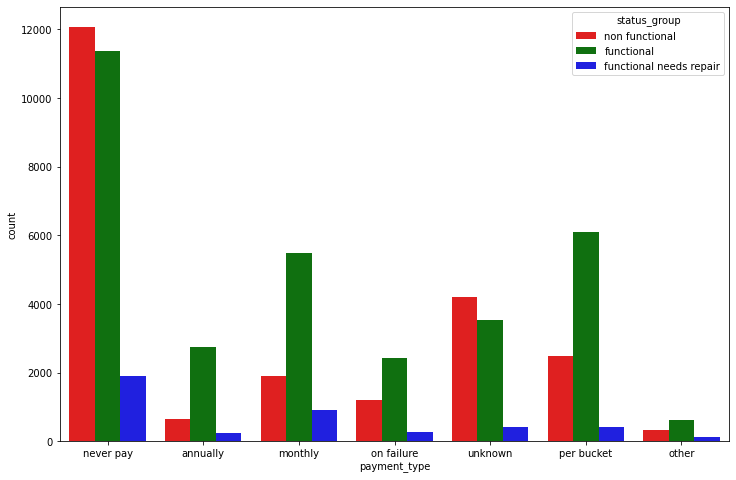

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='payment_type', hue='status_group', data=df, ax=ax, palette=color_status)

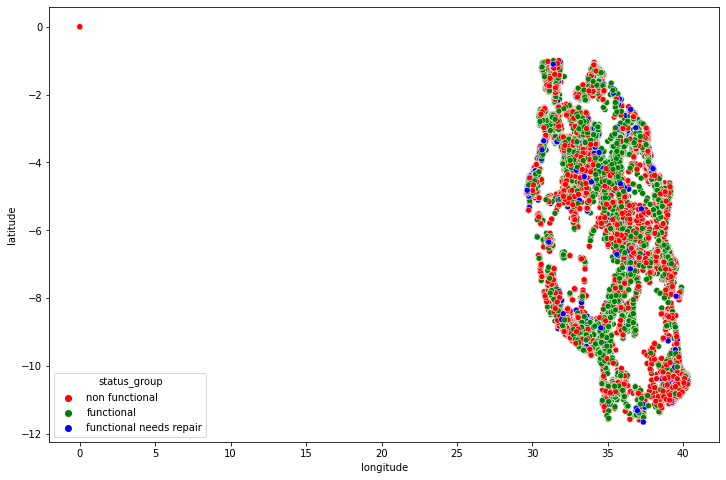

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude', data=df, hue='status_group', ax=ax, palette=color_status)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


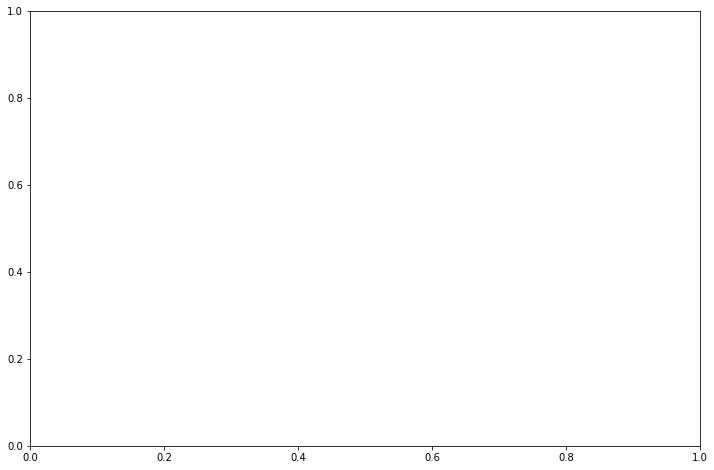

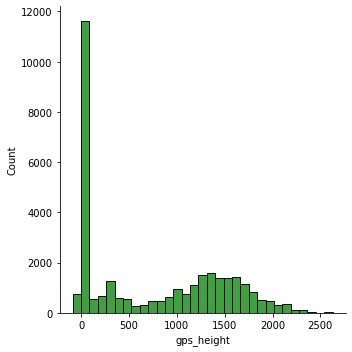

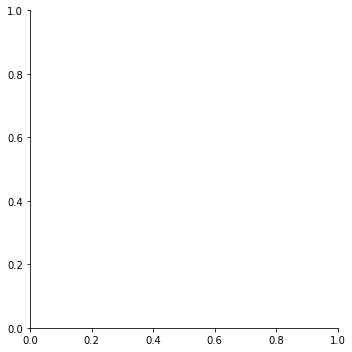

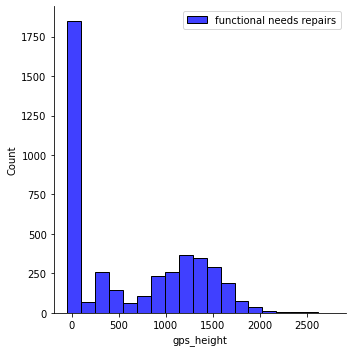

In [ ]:
row_functional = (df['status_group'] == 'functional')
row_non_functional = (df['status_group'] == 'non_functional')
row_repair = (df['status_group'] == 'functional needs repair')
col = 'gps_height'
fig,ax = plt.subplots(figsize=(12,8))
sns.displot(df[col][row_functional], color='green', label='functional', ax=ax)
sns.displot(df[col][row_non_functional], color='red', label='non functional', ax=ax)
sns.displot(df[col][row_repair], color='blue', label='functional needs repairs', ax=ax)
plt.legend()

In [ ]:
data.groupBy(col).count().orderBy(col).show()

+----------+-----+
|gps_height|count|
+----------+-----+
|       -90|    1|
|       -63|    2|
|       -59|    1|
|       -57|    1|
|       -55|    1|
|       -54|    1|
|       -53|    1|
|       -52|    2|
|       -51|    2|
|       -50|    5|
|       -49|    4|
|       -48|    6|
|       -47|    8|
|       -46|    6|
|       -45|    9|
|       -44|    6|
|       -43|   11|
|       -42|   13|
|       -41|   11|
|       -40|   26|
+----------+-----+
only showing top 20 rows

